<a href="https://colab.research.google.com/github/burbox22/sayanghosh91/blob/main/Growth_Guardrails_Chart_viz_0319.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 25.5 MB/s eta 0:00:00


                                            geometry
0  MULTIPOLYGON (((-44.02523 -22.77769, -44.02543...


<Axes: >

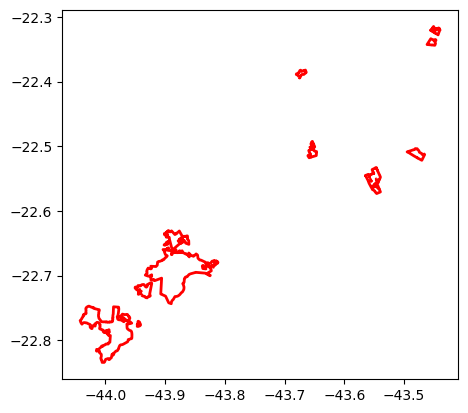

In [3]:
import geopandas as gpd

geojson_path = "/content/drive/MyDrive/Colab Notebooks/DynamicBaseline_ProjectArea_a19186df.geojson"  # Adjust the filename
gdf = gpd.read_file(geojson_path)

# Check the GeoJSON structure
print(gdf.head())

# Plot the boundary
gdf.plot(edgecolor="red", facecolor="none", linewidth=2)


In [4]:
import rasterio

# Define new raster path
new_raster_path = "/content/drive/MyDrive/Colab Notebooks/05a_natRegen_C_accumulation.tif"  # Update with correct filename

# Open and check raster metadata
with rasterio.open(new_raster_path) as src:
    print("New Raster CRS:", src.crs)
    print("New Raster Bounds:", src.bounds)
    print("Raster Shape:", src.shape)


New Raster CRS: EPSG:4326
New Raster Bounds: BoundingBox(left=-176.218092654, bottom=-55.98521682794552, right=181.7785143810456, top=55.432827866)
Raster Shape: (12403, 39852)


In [5]:
import geopandas as gpd
import rasterio

# Load project GeoJSON
geojson_path = "/content/drive/MyDrive/Colab Notebooks/DynamicBaseline_ProjectArea_a19186df.geojson"
gdf = gpd.read_file(geojson_path)

# Function to reproject GeoJSON
def reproject_geojson(gdf, raster_path, save_path):
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs  # Get raster CRS

    if gdf.crs != raster_crs:
        print(f"Reprojecting GeoJSON to match {raster_path} CRS...")
        gdf = gdf.to_crs(raster_crs)

    gdf.to_file(save_path, driver="GeoJSON")
    return save_path

# Define raster paths
raster1_path = "/content/drive/MyDrive/Colab Notebooks/Base_Pot_AGB_MgCha_500m (1).tif"
raster2_path = "/content/drive/MyDrive/Colab Notebooks/05a_natRegen_C_accumulation.tif"

# Save reprojected GeoJSONs
geojson1_path = reproject_geojson(gdf, raster1_path, "/content/drive/MyDrive/Colab Notebooks/v1_2_project_boundary_raster.geojson")
geojson2_path = reproject_geojson(gdf, raster2_path, "/content/drive/MyDrive/Colab Notebooks/v2_2_project_boundary_raster2.geojson")


Reprojecting GeoJSON to match /content/drive/MyDrive/Colab Notebooks/Base_Pot_AGB_MgCha_500m (1).tif CRS...


In [6]:
import geopandas as gpd
import rasterio

# Load project GeoJSON
geojson_path = "/content/drive/MyDrive/Colab Notebooks/DynamicBaseline_ProjectArea_a19186df.geojson"
gdf = gpd.read_file(geojson_path)

# Function to reproject GeoJSON
def reproject_geojson(gdf, raster_path, save_path):
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs  # Get raster CRS

    if gdf.crs != raster_crs:
        print(f"Reprojecting GeoJSON to match {raster_path} CRS...")
        gdf = gdf.to_crs(raster_crs)

    gdf.to_file(save_path, driver="GeoJSON")
    return save_path

# Define raster paths
raster1_path = "/content/drive/MyDrive/Colab Notebooks/Base_Pot_AGB_MgCha_500m (1).tif"
raster2_path = "/content/drive/MyDrive/Colab Notebooks/05a_natRegen_C_accumulation.tif"

# Save reprojected GeoJSONs
geojson1_path = reproject_geojson(gdf, raster1_path, "/content/drive/MyDrive/Colab Notebooks/v1_2_project_boundary_raster.geojson")
geojson2_path = reproject_geojson(gdf, raster2_path, "/content/drive/MyDrive/Colab Notebooks/v2_2_project_boundary_raster2.geojson")


Reprojecting GeoJSON to match /content/drive/MyDrive/Colab Notebooks/Base_Pot_AGB_MgCha_500m (1).tif CRS...


In [7]:
import rasterio.mask
import json
import numpy as np

# Function to clip raster using its corresponding GeoJSON
def clip_raster(raster_path, geojson_path):
    with open(geojson_path) as f:
        geojson_data = json.load(f)
        geojson_geometry = [feature["geometry"] for feature in geojson_data["features"]]

    with rasterio.open(raster_path) as src:
        clipped_raster, _ = rasterio.mask.mask(src, geojson_geometry, crop=True)

    return clipped_raster

# Clip both rasters
clipped_raster1 = clip_raster(raster1_path, geojson1_path)
clipped_raster2 = clip_raster(raster2_path, geojson2_path)


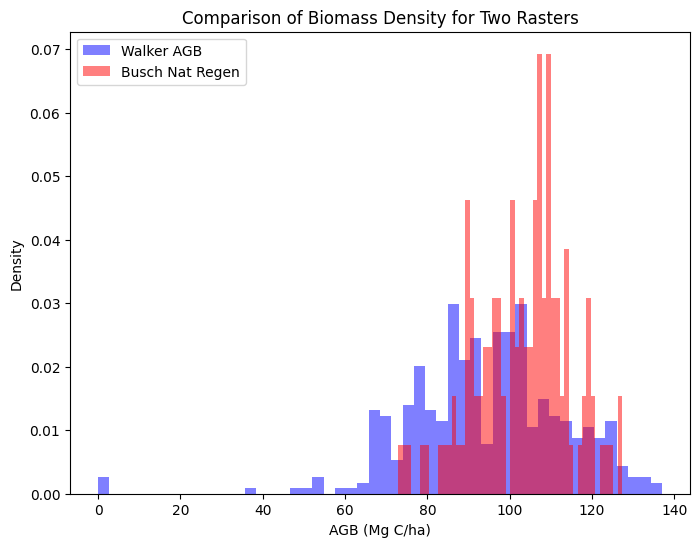

In [8]:
import matplotlib.pyplot as plt

# Convert NoData (-32768) to NaN
nodata_value = -32768
clipped_raster1 = np.where(clipped_raster1 == nodata_value, np.nan, clipped_raster1)
clipped_raster2 = np.where(clipped_raster2 == nodata_value, np.nan, clipped_raster2)

# Flatten and remove NaN values
valid_pixels1 = clipped_raster1[0].flatten()
valid_pixels2 = clipped_raster2[0].flatten()

valid_pixels1 = valid_pixels1[~np.isnan(valid_pixels1)]
valid_pixels2 = valid_pixels2[~np.isnan(valid_pixels2)]

# Plot overlapping histograms
plt.figure(figsize=(8, 6))
plt.hist(valid_pixels1, bins=50, alpha=0.5, label="Walker AGB", color="blue", density=True)
plt.hist(valid_pixels2, bins=50, alpha=0.5, label="Busch Nat Regen", color="red", density=True)
plt.xlabel("AGB (Mg C/ha)")
plt.ylabel("Density")
plt.title("Comparison of Biomass Density for Two Rasters")
plt.legend()
plt.show()


In [9]:
import geopandas as gpd
import rasterio

def reproject_geojson(geojson_path, target_crs, output_path):
    """ Reprojects a GeoJSON to a target CRS and saves it. """
    gdf = gpd.read_file(geojson_path)
    gdf = gdf.to_crs(target_crs)
    gdf.to_file(output_path, driver="GeoJSON")
    return output_path

# Load original GeoJSON
geojson_path = "/content/drive/MyDrive/Colab Notebooks/DynamicBaseline_ProjectArea_a19186df.geojson"

# Get CRS from rasters
with rasterio.open("/content/drive/MyDrive/Colab Notebooks/Base_Pot_AGB_MgCha_500m (1).tif") as src1:
    raster1_crs = src1.crs

with rasterio.open("/content/drive/MyDrive/Colab Notebooks/05a_natRegen_C_accumulation.tif") as src2:
    raster2_crs = src2.crs

# Reproject GeoJSON to match each raster
geojson_raster1_path = "project_boundary_raster1.geojson"
geojson_raster2_path = "project_boundary_raster2.geojson"

reproject_geojson(geojson_path, raster1_crs, geojson_raster1_path)
reproject_geojson(geojson_path, raster2_crs, geojson_raster2_path)

print("✅ GeoJSON reprojected to match both rasters")


✅ GeoJSON reprojected to match both rasters


In [10]:
from rasterio.mask import mask

def clip_raster(raster_path, geojson_path, output_path):
    """ Clips a raster using a GeoJSON boundary. """
    gdf = gpd.read_file(geojson_path)
    geojson_geom = [gdf.geometry[0]]  # Ensure it's in a list

    with rasterio.open(raster_path) as src:
        clipped_data, clipped_transform = mask(src, geojson_geom, crop=True)

        # Update metadata
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": clipped_data.shape[1],
            "width": clipped_data.shape[2],
            "transform": clipped_transform
        })

        # Save clipped raster
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(clipped_data)

# Clip rasters using corresponding GeoJSONs
clipped_raster1_path = "clipped_raster1.tif"
clipped_raster2_path = "clipped_raster2.tif"

clip_raster("/content/drive/MyDrive/Colab Notebooks/Base_Pot_AGB_MgCha_500m (1).tif", geojson_raster1_path, clipped_raster1_path)
clip_raster("/content/drive/MyDrive/Colab Notebooks/05a_natRegen_C_accumulation.tif", geojson_raster2_path, clipped_raster2_path)

print("✅ Rasters clipped using respective GeoJSONs")


✅ Rasters clipped using respective GeoJSONs


In [11]:
from rasterio.warp import Resampling
import numpy as np

def resample_raster(source_path, match_path, output_path):
    """ Resamples a raster to match another raster's resolution and extent. """
    with rasterio.open(source_path) as src, rasterio.open(match_path) as match_src:
        match_transform = match_src.transform
        match_width, match_height = match_src.width, match_src.height

        resampled_data = src.read(
            out_shape=(src.count, match_height, match_width),
            resampling=Resampling.nearest
        )

        out_meta = src.meta.copy()
        out_meta.update({
            "height": match_height,
            "width": match_width,
            "transform": match_transform
        })

        with rasterio.open(output_path, "w", **out_meta) as dst:
            dst.write(resampled_data)

# Check if resampling is needed
with rasterio.open(clipped_raster1_path) as src1, rasterio.open(clipped_raster2_path) as src2:
    shape1 = (src1.count, src1.height, src1.width)
    shape2 = (src2.count, src2.height, src2.width)

if shape1 != shape2:
    resampled_raster2_path = "resampled_raster2.tif"
    resample_raster(clipped_raster2_path, clipped_raster1_path, resampled_raster2_path)
    raster2_final_path = resampled_raster2_path
    print("✅ Raster 2 resampled to match Raster 1")
else:
    raster2_final_path = clipped_raster2_path
    print("✅ No resampling needed")

raster1_final_path = clipped_raster1_path


✅ Raster 2 resampled to match Raster 1


In [12]:
import pandas as pd
import numpy as np
import rasterio

def extract_pixel_values(raster1_path, raster2_path, output_csv):
    """ Extracts pixel values from Raster 1 and both bands of Raster 2, then saves to CSV. """
    with rasterio.open(raster1_path) as src1, rasterio.open(raster2_path) as src2:
        data1 = src1.read(1)  # First band of Raster 1
        data2_band1 = src2.read(1)  # Band A of Raster 2
        data2_band2 = src2.read(2)  # Band K of Raster 2

        # Convert NoData (-32768) to NaN
        nodata_value = -32768
        data1 = np.where(data1 == nodata_value, np.nan, data1)
        data2_band1 = np.where(data2_band1 == nodata_value, np.nan, data2_band1)
        data2_band2 = np.where(data2_band2 == nodata_value, np.nan, data2_band2)

        rows, cols = data1.shape
        transform = src1.transform

        # Store pixel data
        data = []
        for row in range(rows):
            for col in range(cols):
                val1 = data1[row, col]
                val2_A = data2_band1[row, col]
                val2_K = data2_band2[row, col]

                if np.isnan(val1) or np.isnan(val2_A) or np.isnan(val2_K):
                    continue

                x, y = rasterio.transform.xy(transform, row, col)
                data.append([x, y, val1, val2_A, val2_K])

    df = pd.DataFrame(data, columns=["X", "Y", "Raster1_Value", "Raster2_BandA_Value", "Raster2_BandK_Value"])
    df.to_csv(output_csv, index=False)
    print(f"✅ CSV saved: {output_csv}")

# Generate CSV
csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
extract_pixel_values(raster1_final_path, raster2_final_path, csv_path)


✅ CSV saved: /content/drive/MyDrive/Colab Notebooks/raster_comparison.csv


Upload your PD Growth Curve CSV file:


Saving Dummy PD Growth Curve.csv to Dummy PD Growth Curve.csv


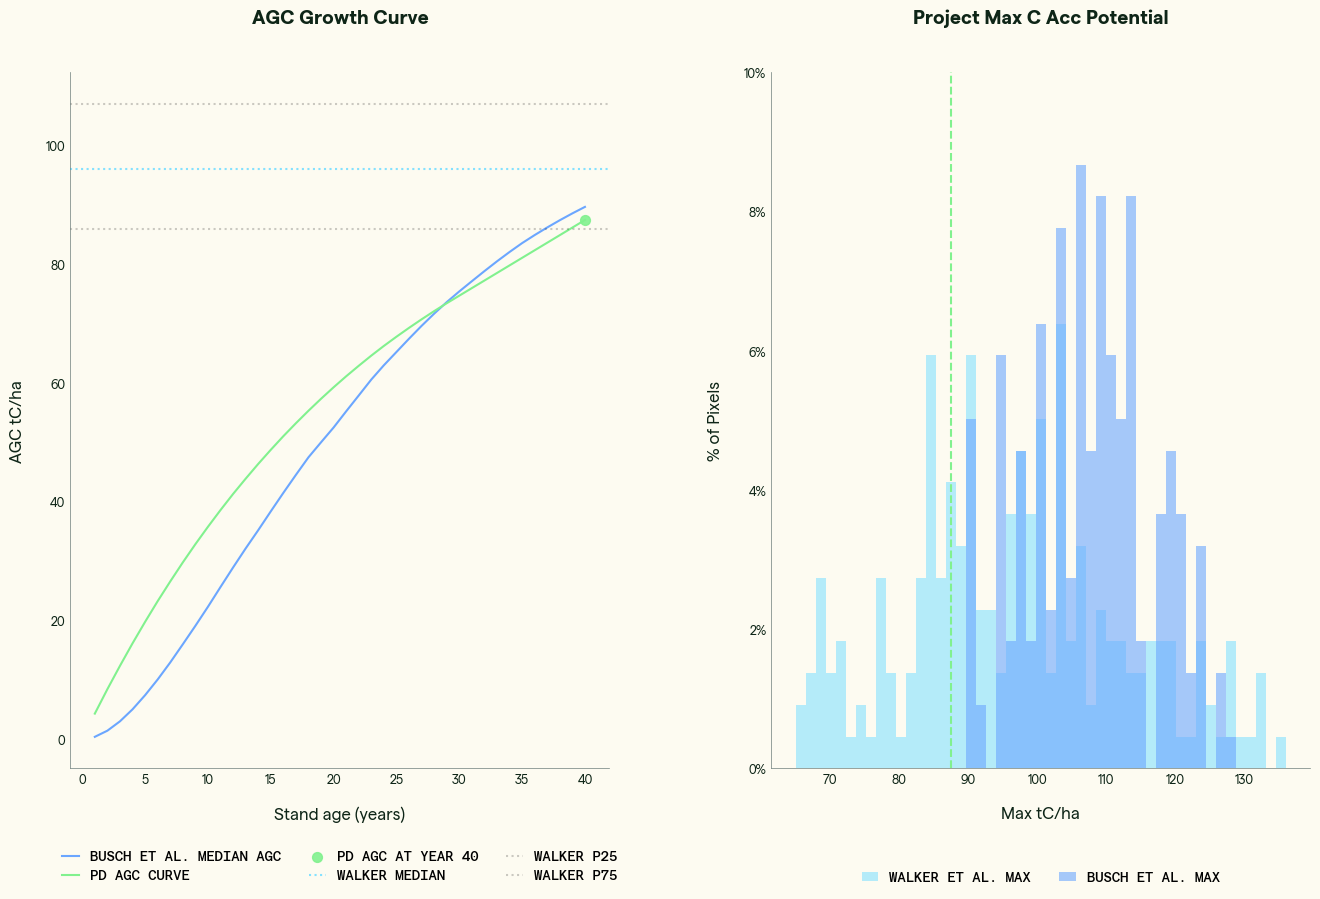

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from google.colab import files

# Define font file paths
matter_bold_path = "/content/drive/MyDrive/Colab Notebooks/Matter-Bold.ttf"
matter_regular_path = "/content/drive/MyDrive/Colab Notebooks/Matter-Regular.ttf"
matter_mono_path = "/content/drive/MyDrive/Colab Notebooks/MatterMono-Medium.ttf"

# Load Fonts
matter_bold = FontProperties(fname=matter_bold_path, size=14)
matter_regular_axis = FontProperties(fname=matter_regular_path, size=12)
matter_regular_ticks = FontProperties(fname=matter_regular_path, size=9)
matter_mono_legend = FontProperties(fname=matter_mono_path, size=10)

# ---- Upload and Read User CSV (PD Dummy Curve) ----
print("Upload your PD Growth Curve CSV file:")
uploaded = files.upload()
csv_path = list(uploaded.keys())[0]  # Get the uploaded file name
df_user = pd.read_csv(csv_path)
df_user.columns = ["Years", "AGC"]

# Extract crediting period (last year) and corresponding AGC
crediting_period = df_user["Years"].max()
user_agc = df_user.loc[df_user["Years"] == crediting_period, "AGC"].values[0]

# ---- Load Raster Comparison CSV ----
raster_csv_path = "/content/drive/MyDrive/Colab Notebooks/raster_comparison.csv"
df = pd.read_csv(raster_csv_path)

# Extract values for Walker et al. and Busch et al.
raster1_values = df["Raster1_Value"].dropna().values
raster2_bandA_values = df["Raster2_BandA_Value"].dropna().values

# Generate Chapman-Richards Growth Curves (Busch et al.)
t_values = np.arange(1, crediting_period + 1)
agc_curves = [
    row["Raster2_BandA_Value"] * (1 - np.exp(-row["Raster2_BandK_Value"] * t_values)) ** 2
    for _, row in df.iterrows()
]
median_agc_curve = np.median(agc_curves, axis=0)

# Compute Walker et al. Median, P25, P75
walker_median = np.median(raster1_values)
p25 = np.percentile(raster1_values, 25)
p75 = np.percentile(raster1_values, 75)

# ---- Define Colors ----
color_pd_agc = "#81F18E"   # Lidar Green
color_busch_median = "#6BA6FF"  # Flax
color_walker_median = "#84E1FF"  # Glacier
color_charcoal = "#000000"  # Black for P25 & P75 (with adjusted opacity)
color_eggshell = "#FDFBF1"
color_pine = "#0E2517"  # Text color
color_stone = "#6D7E7B"  # Axis line color

# ---- Create Figure (Wider Format: 4:3) ----
fig, axes = plt.subplots(1, 2, figsize=(16, 12), facecolor=color_eggshell)  # 4:3 aspect ratio

for ax in axes:
    ax.set_facecolor(color_eggshell)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color(color_stone)
    ax.spines["bottom"].set_color(color_stone)
    ax.spines["left"].set_linewidth(0.5)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(axis='both', labelsize=9, colors=color_pine, length=0)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(matter_regular_ticks)
        label.set_color(color_pine)

# ---- 1️⃣ AGC Growth Curve (Left) ----
ax1 = axes[0]
ax1.plot(t_values, median_agc_curve, color=color_busch_median, linewidth=1.5, label="BUSCH ET AL. MEDIAN AGC")
ax1.plot(df_user["Years"], df_user["AGC"], color=color_pd_agc, linewidth=1.5, label="PD AGC CURVE")
ax1.scatter(crediting_period, user_agc, color=color_pd_agc, edgecolor=color_pd_agc, s=50, alpha=0.9, label=f"PD AGC AT YEAR {crediting_period}")
ax1.axhline(walker_median, color=color_walker_median, linestyle='dotted', linewidth=1.5, label="WALKER MEDIAN")
ax1.axhline(p25, color=color_charcoal, linestyle='dotted', linewidth=1.5, alpha=0.2, label="WALKER P25")
ax1.axhline(p75, color=color_charcoal, linestyle='dotted', linewidth=1.5, alpha=0.2, label="WALKER P75")
ax1.set_xlabel("Stand age (years)", fontsize=12, color=color_pine, labelpad=15, fontproperties=matter_regular_axis)
ax1.set_ylabel("AGC tC/ha", fontsize=12, color=color_pine, labelpad=15, fontproperties=matter_regular_axis)
ax1.set_title("AGC Growth Curve", fontsize=14, color=color_pine, fontproperties=matter_bold, pad=35)

# Adjusted legend position (moved up)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.10), frameon=False, prop=matter_mono_legend, fontsize=10, ncol=3, handleheight=0.7, handlelength=1.2)

# ---- 2️⃣ Project Max C Acc Potential (Right) ----
ax2 = axes[1]
bins = np.linspace(raster1_values.min(), raster1_values.max(), 50)

# Normalizing the histograms to percentage
ax2.hist(raster1_values, bins, alpha=0.6, color=color_walker_median, label="WALKER ET AL. MAX", weights=np.ones(len(raster1_values)) / len(raster1_values) * 100)
ax2.hist(raster2_bandA_values, bins, alpha=0.6, color=color_busch_median, label="BUSCH ET AL. MAX", weights=np.ones(len(raster2_bandA_values)) / len(raster2_bandA_values) * 100)

# Add user AGC as a vertical dashed line
ax2.axvline(user_agc, color=color_pd_agc, linestyle='dashed', linewidth=1.5)

# Set labels and title with correct formatting
ax2.set_xlabel("Max tC/ha", fontsize=12, color=color_pine, labelpad=15, fontproperties=matter_regular_axis)
ax2.set_ylabel("% of Pixels", fontsize=12, color=color_pine, labelpad=15, fontproperties=matter_regular_axis)
ax2.set_title("Project Max C Acc Potential", fontsize=14, color=color_pine, fontproperties=matter_bold, pad=35)

# Format y-axis labels as percentages
ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels([f"{int(y)}%" for y in ax2.get_yticks()], fontproperties=matter_regular_ticks, color=color_pine)

# Ensure axis lines on the right chart match the left chart
ax2.spines["left"].set_color(color_stone)
ax2.spines["bottom"].set_color(color_stone)
ax2.spines["left"].set_linewidth(0.5)
ax2.spines["bottom"].set_linewidth(0.5)

# Adjusted legend position (moved up)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.13), frameon=False, prop=matter_mono_legend, fontsize=10, ncol=2, handleheight=0.7, handlelength=1.2)

# Final Adjustments and Save
plt.subplots_adjust(bottom=0.3, wspace=0.3)
plt.show()
